In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 5
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2017-04-17', datetime.date(2022, 4, 17))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


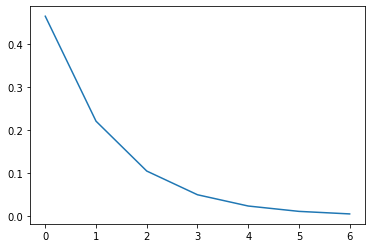

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                   Close                    High        ...  \
  ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
0   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
1   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
2   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
3   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
4   NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN  0.011840            1.0            NaN   
1            NaN             NaN  0.006415            1.0       0.994589   
2            NaN             NaN -0.002226            1.0       0.991396   
3            NaN             NaN -0.005564            1.0       0.996668   
4            NaN             NaN -0.013576            1.0       0.992021   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN  0.011840            1.0            NaN             NaN  
1        0.994589  0.006465            1.0       0.994640        0.994640  
2        0.991396 -0.002154            1.0       0.991417        0.991417  
3        0.996668 -0.005253            1.0       0.996907        0.996907  
4        0.992021 -0.013069            1.0       0.992214        0.992214  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2512   2022-04-08
2513   2022-04-11
2514   2022-04-12
2515   2022-04-13
2516   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                   Close                    High        ...  \
     ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC ^NYA ^W5000 ^GSPC ^IXIC  ...   
Date                                                              ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   
NaT    NaN   NaN  NaN    NaN   NaN   NaN  NaN    NaN   NaN   NaN  ...   

     DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
             ^W5000          ^W5000     mine1          mine1          mine1   
Date                                                                          
NaT             NaN             NaN  0.011840            1.0            NaN   
NaT             NaN             NaN  0.006415            1.0       0.994589   
NaT             NaN             NaN -0.002226            1.0       0.991396   
NaT             NaN             NaN -0.005564            1.0       0.996668   
NaT             NaN             NaN -0.013576            1.0       0.992021   

     OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
               mine1     mine2          mine2          mine2           mine2  
Date                                                                          
NaT              NaN  0.011840            1.0            NaN             NaN  
NaT         0.994589  0.006465            1.0       0.994640        0.994640  
NaT         0.991396 -0.002154            1.0       0.991417        0.991417  
NaT         0.996668 -0.005253            1.0       0.996907        0.996907  
NaT         0.992021 -0.013069            1.0       0.992214        0.992214  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6230439877846239
Refitting current best...
Current best ma returns: 1.771869549216928
Fraction Invested: 0.9999798769853651
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.771882388076694
Invested: 0.9999798769853651
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6230439877846239
Refitting current best...
Current best ew_ma returns: 1.7905556229587019
Fraction Invested: 0.9999991192494154
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.7919050711499738
Invested: 0.9999991192494154
Round: 180


Beginning rel_minmax method...
----------------------------

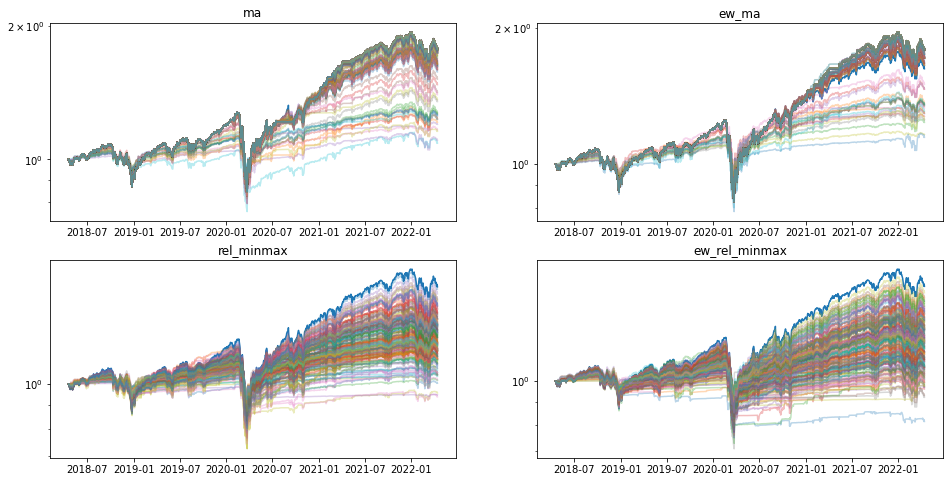

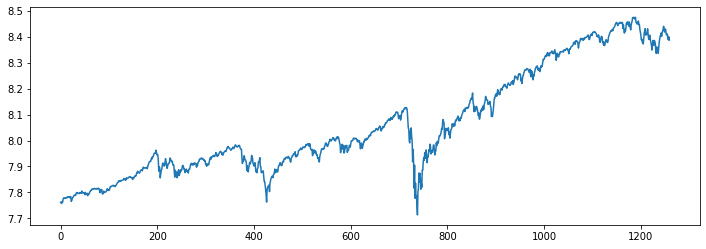

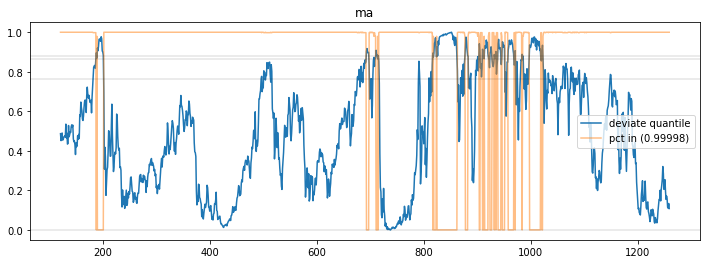

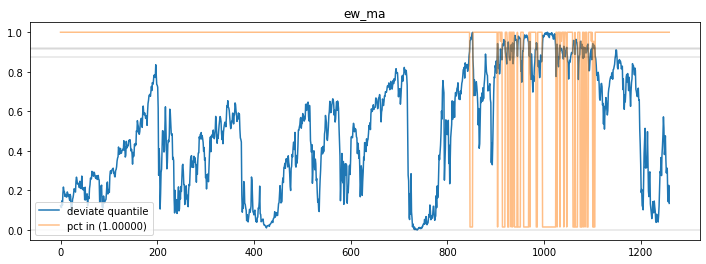

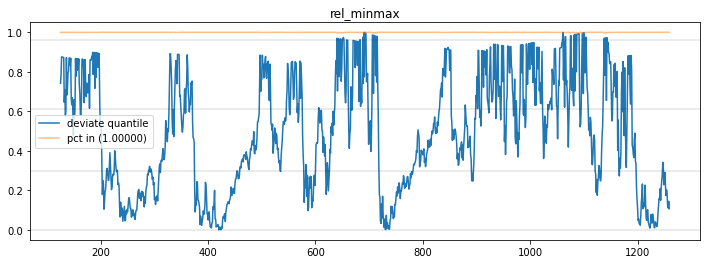

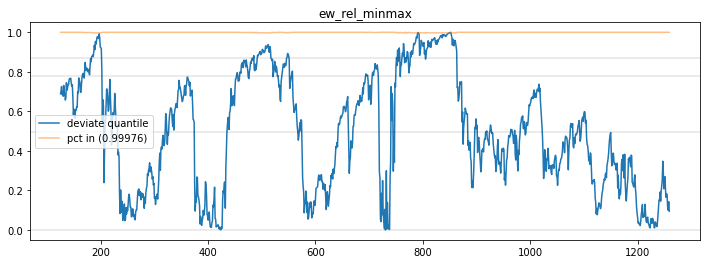

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.8336624821876362
Refitting current best...
Current best ma returns: 2.0171349898151583
Fraction Invested: 0.9999420530576263
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.0171351469695176
Invested: 0.9999420530576263
New best: 2.017171516817417
Invested: 0.9999420530576263
New best: 2.038654655676487
Invested: 0.9999420530576263
New best: 2.0386654850723227
Invested: 0.9999420530576263
New best: 2.1049129614285276
Invested: 0.9999420530576263
New best: 2.1049134549674915
Invested: 0.9999379389457068
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.8336624821876362
Refittin

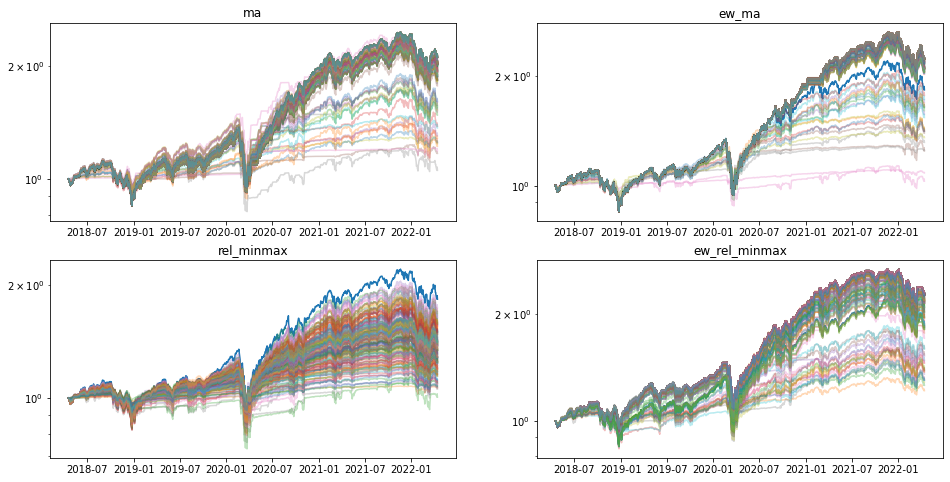

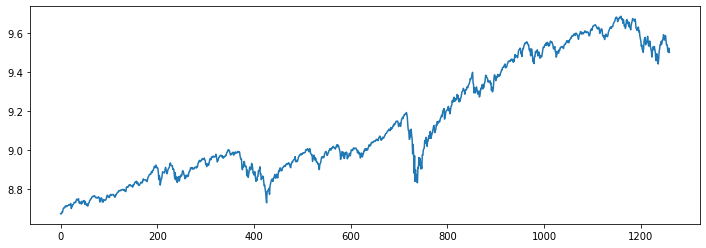

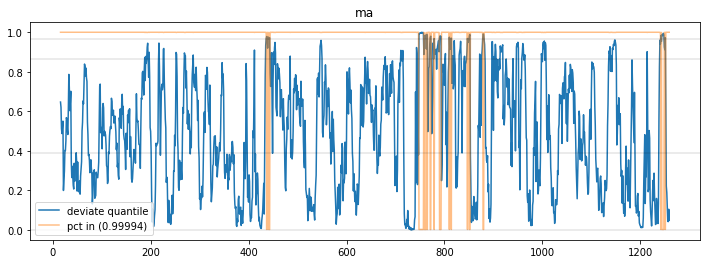

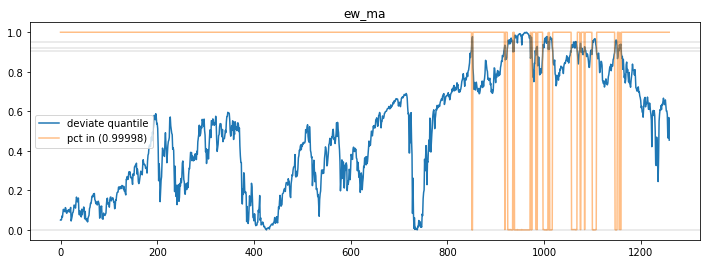

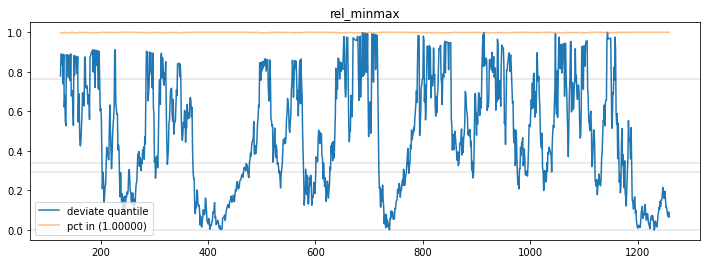

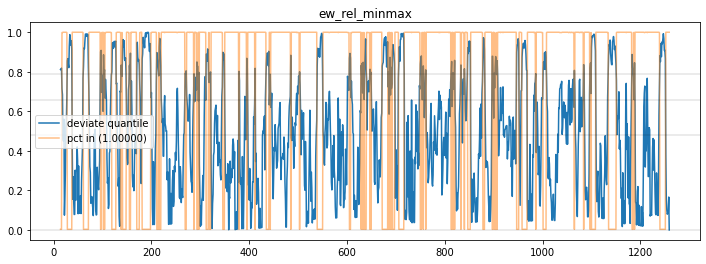

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.2995295102537927
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.2995295102537927
Refitting current best...
Current best ew_ma returns: 1.3483895146392169
Fraction Invested: 0.9998750523043638
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.3483901764787514
Invested: 0.9998750523043638
New best: 1.3484051431442037
Invested: 0.999916021858141
Round: 180


Beginning rel_minmax method...
---------------------------------------------

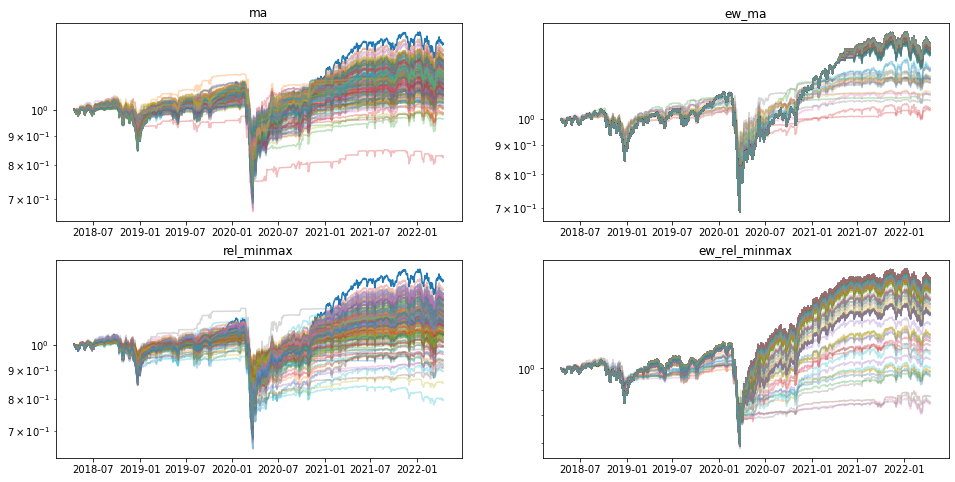

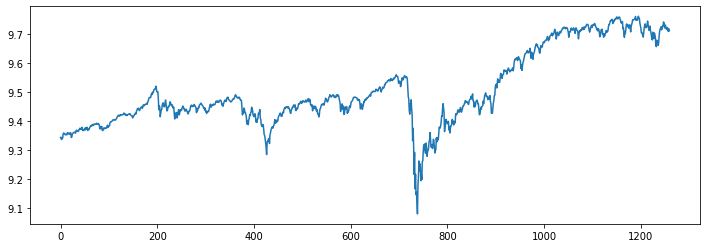

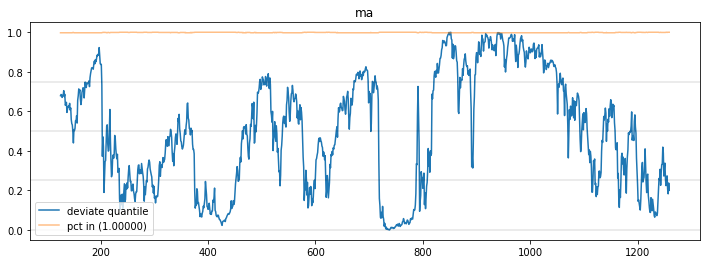

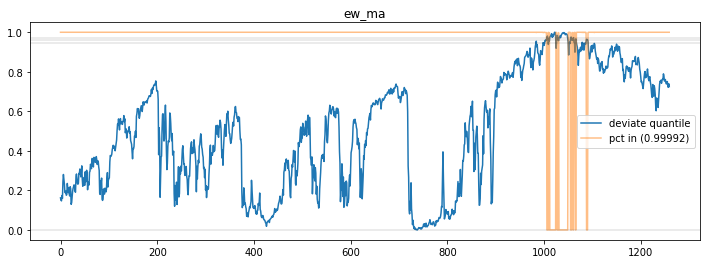

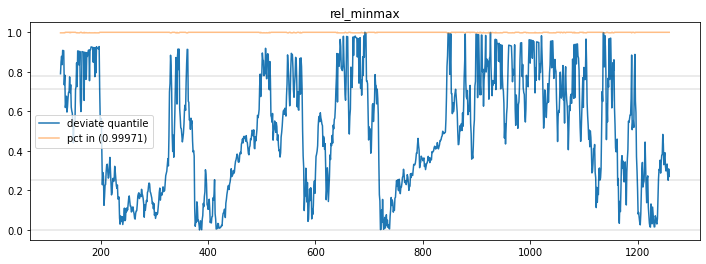

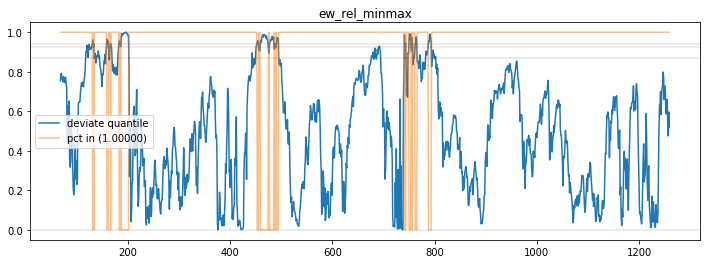

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.572291859447484
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.572291859447484
Refitting current best...
Current best ew_ma returns: 1.6299801776972538
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 1.6299806150884506
Invested: 1.0
New best: 1.662124306231373
Invested: 1.0
New best: 1.6837828628753655
Invested: 1.0
New best: 1.6838076873625298
Invested: 1.0
New best: 1.6939907410737438
Invested: 1.0
New be

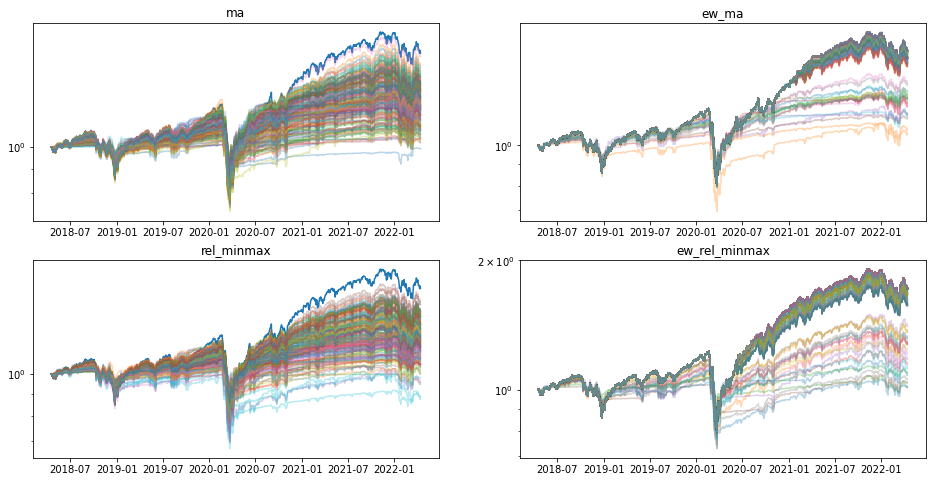

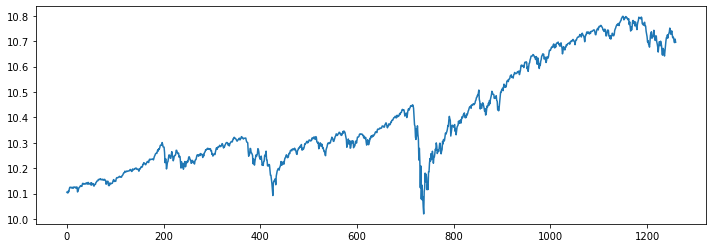

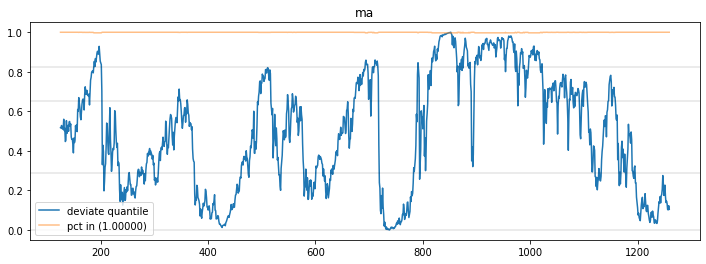

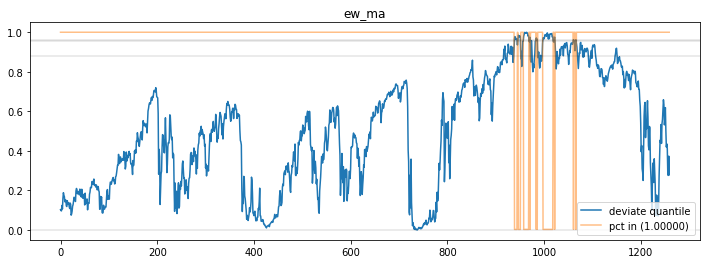

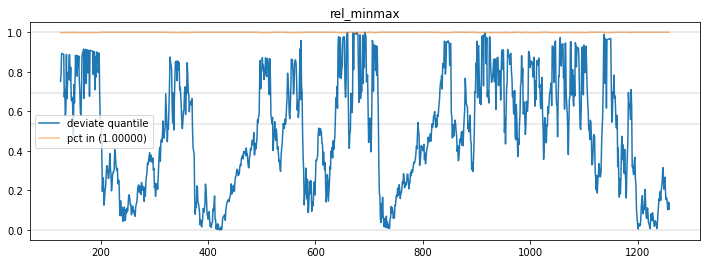

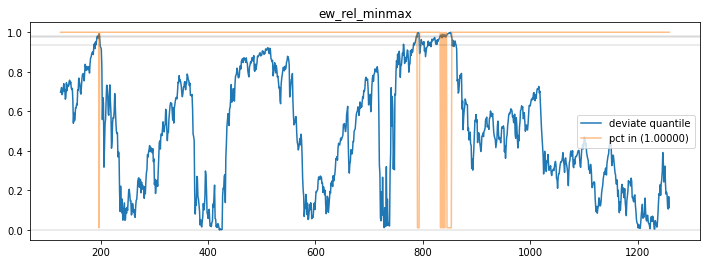

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.178223885610853
Refitting current best...
Current best ma returns: 5.007013374372886
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.178223885610853
Refitting current best...
Current best ew_ma returns: 4.465332000676125
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.178223885610853
Refitting current best...
Fraction Invested: 1
Beginning random search...
Rou

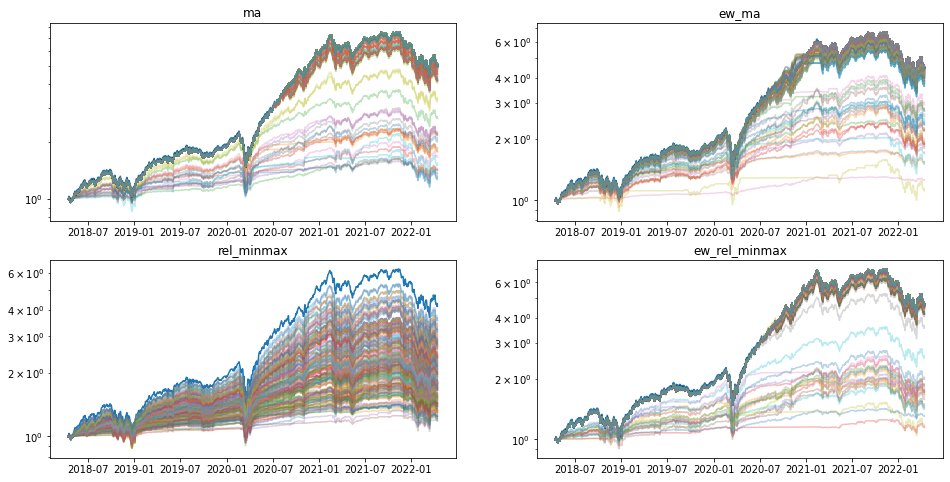

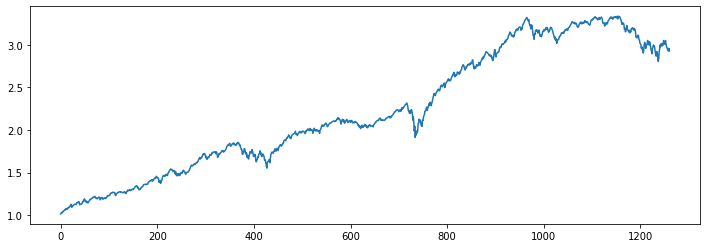

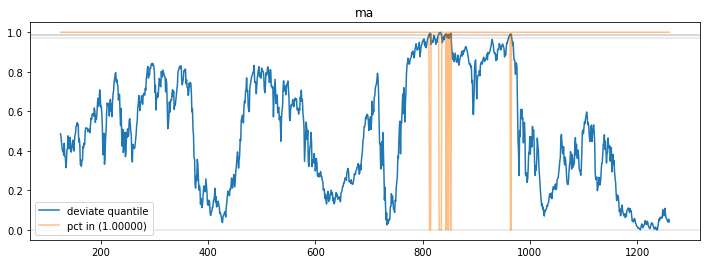

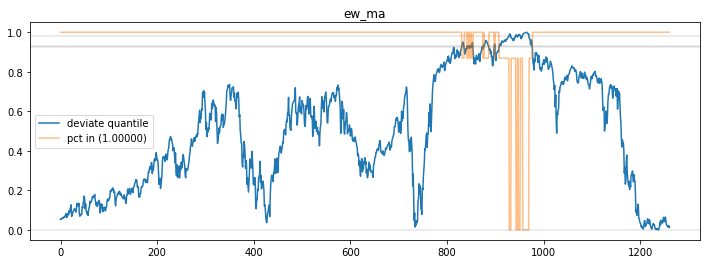

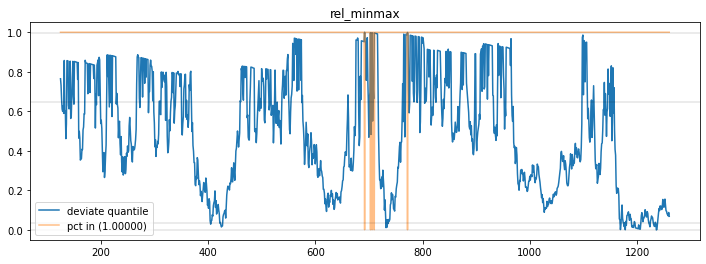

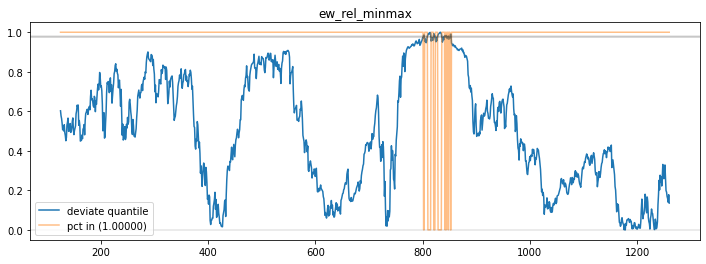

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.098129497967142
Refitting current best...
Current best ma returns: 2.4722223466799274
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.4722226335850412
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.098129497967142
Refitting current best...
Current best ew_ma returns: 2.8250550938403447
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.825055102811646
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 2.0981294

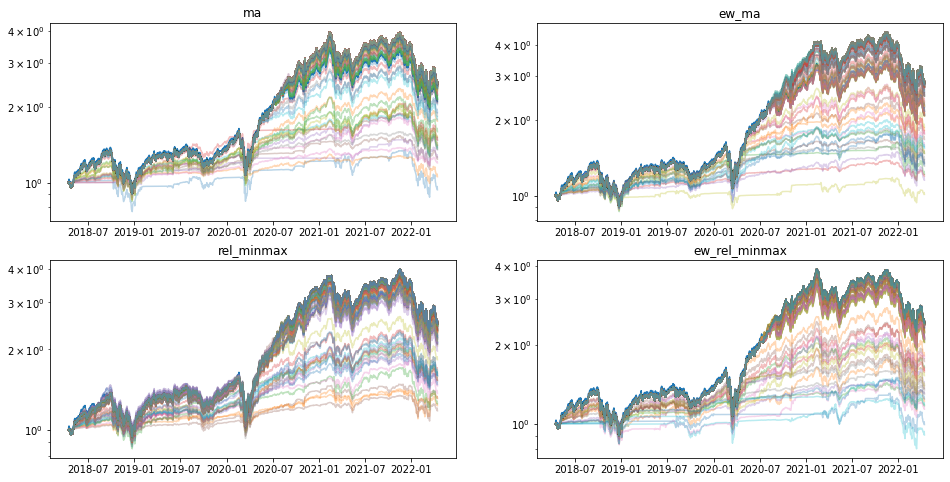

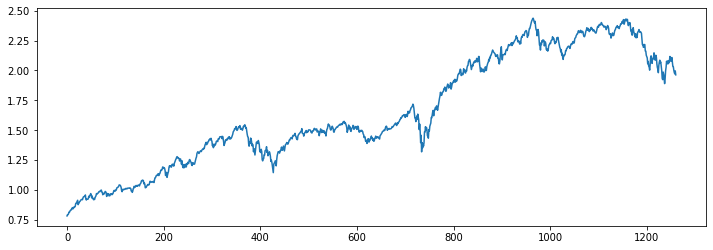

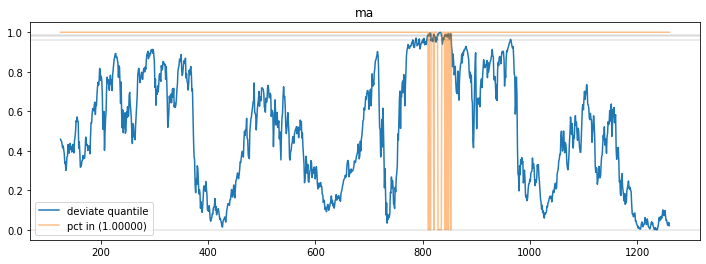

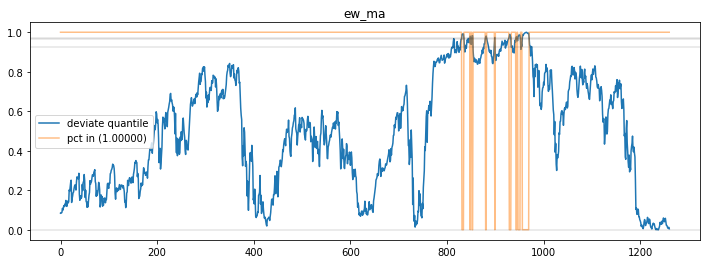

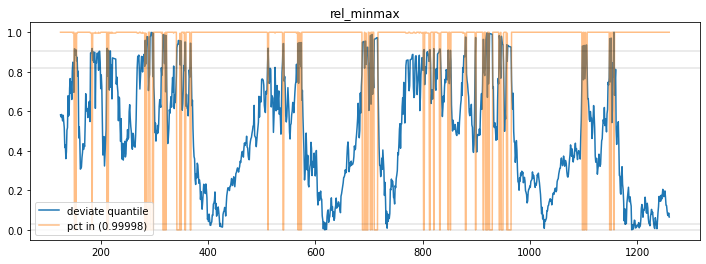

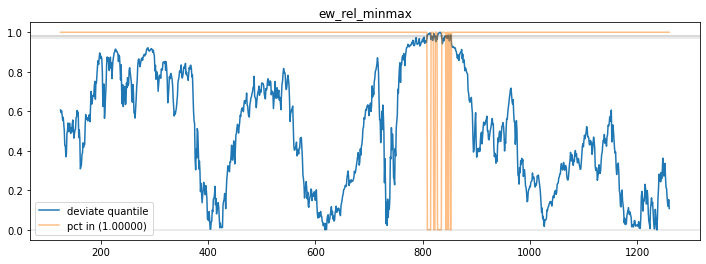

Saving mine2 params...


In [21]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [22]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [23]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 1.7919050711499738 (ew_ma)
  0.99999912 in
time param: 74
qs:
(0.0000 - 0.8732): 1.0000
(0.8732 - 0.9127): 0.9999
(0.9127 - 0.9216): 0.9544
(0.9216 - 1.0000): 0.0148

^IXIC:
  Best Return: 2.2704804189441257 (ew_rel_minmax)
  0.99999980 in
time param: 15
qs:
(0.0000 - 0.4798): 1.0000
(0.4798 - 0.6569): 0.9999
(0.6569 - 0.7865): 0.9984
(0.7865 - 1.0000): 0.0032

^NYA:
  Best Return: 1.5352722049238305 (ew_rel_minmax)
  0.99999953 in
time param: 69
qs:
(0.0000 - 0.8683): 1.0000
(0.8683 - 0.9232): 0.9999
(0.9232 - 0.9387): 0.9983
(0.9387 - 1.0000): 0.0003

^W5000:
  Best Return: 1.7219853465800399 (ew_rel_minmax)
  0.99999918 in
time param: 126
qs:
(0.0000 - 0.9359): 1.0000
(0.9359 - 0.9751): 0.9999
(0.9751 - 0.9829): 0.9989
(0.9829 - 1.0000): 0.0110

mine1:
  Best Return: 5.007013374372886 (ma)
  1.00000000 in
time param: 126
qs:
(0.0000 - 0.9689): 1.0000
(0.9689 - 0.9847): 1.0000
(0.9847 - 0.9883): 0.9996
(0.9883 - 1.0000): 0.0007

mine2:
  Best Return: 2.82505510

{'^GSPC': {'best_return': 1.7919050711499738, 'pct_in': 0.9999991192494154},
 '^IXIC': {'best_return': 2.2704804189441257, 'pct_in': 0.9999998038096501},
 '^NYA': {'best_return': 1.5352722049238305, 'pct_in': 0.999999531592252},
 '^W5000': {'best_return': 1.7219853465800399, 'pct_in': 0.9999991823636122},
 'mine1': {'best_return': 5.007013374372886, 'pct_in': 1.0},
 'mine2': {'best_return': 2.825055102811646, 'pct_in': 1.0}}

In [24]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 1.7919050711499738,
  'pct_in': 0.9999991192494154,
  'weight': 0.10403974546360706},
 '^IXIC': {'best_return': 2.2704804189441257,
  'pct_in': 0.9999998038096501,
  'weight': 0.23822155985617788},
 '^NYA': {'best_return': 1.5352722049238305,
  'pct_in': 0.999999531592252,
  'weight': 0.18140618801646013},
 '^W5000': {'best_return': 1.7219853465800399,
  'pct_in': 0.9999991823636122,
  'weight': 0.09520718830482244},
 'mine1': {'best_return': 5.007013374372886,
  'pct_in': 1.0,
  'weight': 0.09917964085364761},
 'mine2': {'best_return': 2.825055102811646,
  'pct_in': 1.0,
  'weight': 0.17323182519210933}}

In [25]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [26]:
!say qp 5 is dunzo